In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import io
from google.colab import files

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import io
from google.colab import files

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
# 1. Load the data
# Option 1: Upload the file through Colab interface
print("Please upload your descriptions_labeled.csv file:")
uploaded = files.upload()

# Option 2: Or uncomment and use this if your file is in Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/path_to_your_file/descriptions_labeled.csv')

# Load the uploaded file
for filename in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nClass distribution:")
print(df['completion'].value_counts())

Please upload your descriptions_labeled.csv file:


Saving descriptions_labeled.csv to descriptions_labeled (1).csv
Dataset shape: (2000, 2)

First few rows:
                completion                                             prompt
0                   tracks  Southbound [A][C] trains are disrupted in Manh...
1                   tracks  Southbound [A][C][E] trains are disrupted in M...
2                   tracks  Southbound [A][C][E] trains are disrupted in M...
3              subway_cars  Northbound [F] trains are running with delays ...
4  police_medical_activity  [2] trains are running with delays in both dir...

Class distribution:
completion
subway_cars                790
police_medical_activity    493
tracks                     276
other                      260
signal                     170
stations_structures         11
Name: count, dtype: int64


In [28]:
# 2. Text Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(cleaned_tokens)

# Apply preprocessing to prompts
print("\nPreprocessing text data...")
df['processed_prompt'] = df['prompt'].apply(preprocess_text)


Preprocessing text data...


In [29]:
# 3. Split data into train and test sets
X = df['processed_prompt']
y = df['completion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 1600
Testing set size: 400


In [30]:
# 4. Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Show the top features (words) from TF-IDF
feature_names = vectorizer.get_feature_names_out()
print("\nTop features from TF-IDF:")
print(feature_names[:20])


Top features from TF-IDF:
['abcd' 'able' 'ac' 'acd' 'ace' 'acef' 'acf' 'activate' 'activated' 'ad'
 'address' 'addressed' 'addressing' 'ae' 'airport' 'alabama' 'allerton'
 'along' 'aquarium' 'area']


In [31]:
# 5. Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get the number of unique classes
num_classes = len(label_encoder.classes_)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to one-hot encoding for neural network
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)


Number of classes: 6
Classes: ['other' 'police_medical_activity' 'signal' 'stations_structures'
 'subway_cars' 'tracks']


In [32]:
# 6. Build a Neural Network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        66,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,334 (294.27 KB)

 Trainable params: 75,334 (294.27 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# 7. Train the model with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Convert sparse matrix to dense for TensorFlow
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

history = model.fit(
    X_train_dense,
    y_train_categorical,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3757 - loss: 1.7200 - val_accuracy: 0.5094 - val_loss: 1.3883
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5823 - loss: 1.2583 - val_accuracy: 0.6906 - val_loss: 0.8791
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7289 - loss: 0.7625 - val_accuracy: 0.8531 - val_loss: 0.5073
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8875 - loss: 0.4532 - val_accuracy: 0.9781 - val_loss: 0.2786
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9502 - loss: 0.2608 - val_accuracy: 0.9844 - val_loss: 0.1558
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9741 - loss: 0.1605 - val_accuracy: 0.9875 - val_loss: 0.1011
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.1165 - val_accuracy: 0.9906 - val_loss: 0.0736
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9874 - loss: 0.0863 - val_accuracy: 0.9906 - val_loss

In [34]:
# 8. Evaluate the model
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test_encoded

# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Model Evaluation:
Accuracy: 0.9950

Classification Report:
                         precision    recall  f1-score   support

                  other       0.98      1.00      0.99        52
police_medical_activity       1.00      1.00      1.00        99
                 signal       1.00      1.00      1.00        34
    stations_structures       0.00      0.00      0.00         2
            subway_cars       1.00      1.00      1.00       158
                 tracks       0.98      1.00      0.99        55

               accuracy                           0.99       400
              macro avg       0.83      0.83      0.83       400
           weighted avg       0.99      0.99      0.99       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


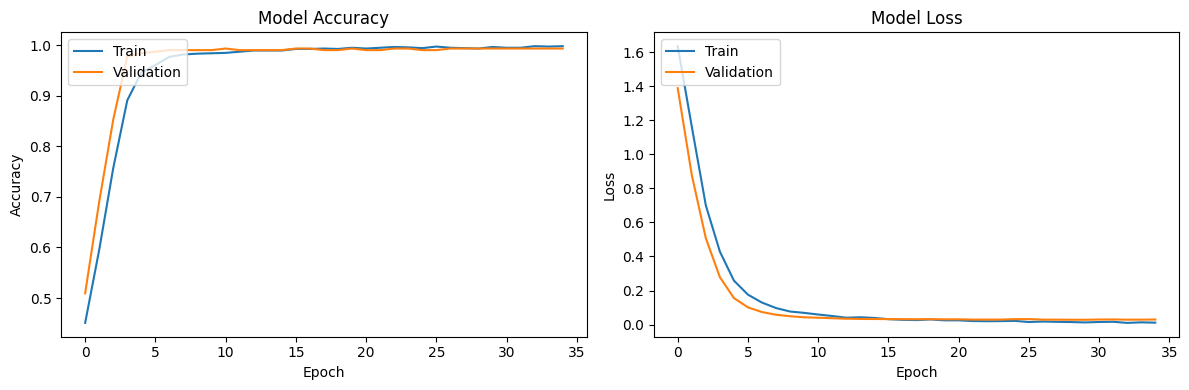

In [35]:
# 9. Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

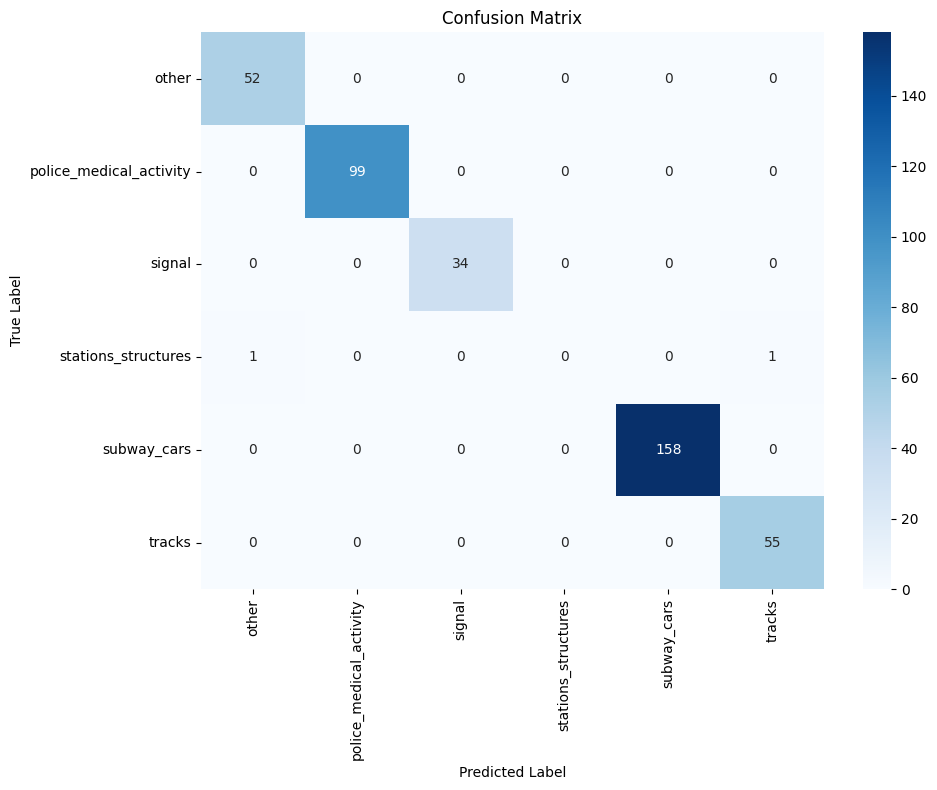

In [36]:
# 10. Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [37]:
# 11. Function to make predictions on new data
def predict_category(text, model, vectorizer, label_encoder):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_tfidf = vectorizer.transform([processed_text]).toarray()

    # Predict
    prediction = model.predict(text_tfidf)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = label_encoder.classes_[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return predicted_class, confidence

In [38]:
# 12. Test on a few examples
test_examples = [
    "Northbound [F] trains are running with delays after a train with mechanical problems at 34 St.",
    "Southbound [A] trains are running with delays after NYPD responded to an unauthorized person on the tracks near Hoyt-Schermerhorn Sts.",
    "[2][3] trains are running with delays after NYPD responded to an incident at Chambers St.",
    "Southbound [A][C] trains are running with delays in Manhattan while we addressed a switch problem at Chambers St."
]

print("\nPredictions on test examples:")
for example in test_examples:
    category, confidence = predict_category(example, model, vectorizer, label_encoder)
    print(f"Text: {example}")
    print(f"Predicted category: {category}")
    print(f"Confidence: {confidence:.4f}\n")



Predictions on test examples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Text: Northbound [F] trains are running with delays after a train with mechanical problems at 34 St.
Predicted category: subway_cars
Confidence: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: Southbound [A] trains are running with delays after NYPD responded to an unauthorized person on the tracks near Hoyt-Schermerhorn Sts.
Predicted category: police_medical_activity
Confidence: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: [2][3] trains are running with delays after NYPD responded to an incident at Chambers St.
Predicted category: police_medical_activity
Confidence: 0.9959

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: Southbound [A][C] trains are running with delays in Manhattan while we addressed a switch problem at Chambers St.
Predicted category: tracks
Confidence: 0.9987



In [39]:
# 13. Save the model and required components for later use
model.save("subway_alert_classifier_model.keras")

# Save vectorizer and label encoder for later use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model and components saved successfully!")

Model and components saved successfully!
